### Introduction
This notebook was used to try some things. 

### Configuration

In [1]:
from dataclasses import dataclass

@dataclass
class Config: 
    mode = "train" # ['train', 'eval'] 
    debug = True
    output_dir = "lesion-filling-256-cond-circle" 

    #dataset config
    dataset_train_path = "./datasets/filling/dataset_train/imgs"
    segm_train_path = "./datasets/filling/dataset_train/segm"
    masks_train_path = "./datasets/filling/dataset_train/masks"
    dataset_eval_path = "./datasets/filling/dataset_eval/imgs"
    segm_eval_path = "./datasets/filling/dataset_eval/segm"
    masks_eval_path = "./datasets/filling/dataset_eval/masks" 
    target_shape = None # During preprocessing the img gets transformered to this shape (computationally expensive)  
    unet_img_shape = (256,256) # This defines the input layer of the model
    channels = 3 # the number of input channels: 1 for grayscale img, 1 for img_voided, 1 for mask
    restrict_train_slices = "segm" # Defines which 2D slices are used from the 3D MRI ['mask', 'segm', or 'unrestricted']
    restrict_eval_slices = "mask" # Defines which 2D slices are used from the 3D MRI ['mask', 'segm', or 'unrestricted']
    restrict_mask_to_wm = False # Restricts lesion masks to white matter based on segmentation
    proportion_training_circular_masks = 1.0 # Defines if random circular masks should be used instead of the provided lesion masks. 
                                             # 1 is 100% random circular masks and 0 is 100% lesion masks.
    train_connected_masks = False # The distribution of the masks is extended by splitting the masks into several smaller connected components.  	 
    brightness_augmentation = True	# The training data gets augmented with randomly applied ColorJitter. 
    num_dataloader_workers = 8 # how many subprocesses to use for data loading

    # train config 
    num_epochs = 900 
    sorted_slice_sample_size = 1 # The number of sorted slices within one sample. Defaults to 1.
                                    # This is needed for the pseudo3Dmodels, where the model expects that the slices within one batch
                                    # are next to each other in the 3D volume.
    train_batch_size = None
    effective_train_batch_size = 32 # The train_batch_size gets recalculated to this batch size based on accumulation_steps and number of GPU's.
	                                # For pseudo3D models the sorted_slice_sample_size gets calculcated to this batch size. 
                                    # The train_batch_size and eval_batch_size should be 1. 
    eval_batch_size = 16
    sorted_slice_sample_size = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500 
    use_min_snr_loss = False
    snr_gamma = 5
    gradient_accumulation_steps = 1 
    mixed_precision = "fp16" # `no` for float32, `fp16` for automatic mixed precision  

    # evaluation config
    num_inference_steps = 50
    evaluate_2D_epochs = 18 # The interval at which to evaluate the model on 2D images.  
    evaluate_3D_epochs = 1000 # The interval at which to evaluate the model on 3D images.    
    evaluate_num_batches = 30 # Number of batches used for evaluation. -1 means all batches.  
    evaluate_num_batches_3d = -1 # Number of batches used for evaluation. -1 means all batches.      
    evaluate_unconditional_img = False # Used for unconditional models to generate some samples without the repaint pipeline. 
    deactivate_2D_evaluation = False
    deactivate_3D_evaluation = True
    img3D_filename = "T1" # Filename to save the processed 3D images  
    eval_loss_timesteps = [20,80,140,200,260,320,380,440,560,620,680,740,800,860,920,980] # List of timesteps to evalute validation loss.
    eval_mask_dilation = 0 # dilation value for masks
    add_lesion_technique = None # Used for synthesis only. 
                                # ['empty', 'mean_intensity', 'other_lesions_1stQuantile', 'other_lesions_mean', 
                                # 'other_lesions_median', 'other_lesions_3rdQuantile', 'other_lesions_99Quantile'] 
    intermediate_timestep = None # Used for synthesis only. Diffusion process starts from this timesteps. 
                                 # Num_inference_steps means the whole pipeline and 1 the last step. 
    jump_length = None # Used for unconditional lesion filling only. Defines the jump_length from the repaint paper.
    jump_n_sample = None # Used for unconditional lesion filling only. Defines the jump_n_sample from the repaint paper.
    log_csv = False # saves evaluation metrics as csv 
    seed = 0 # used for dataloader sampling and generation of the initial noise to start the diffusion process
config = Config()

In [2]:
import torch
import numpy as np
import accelerate
accelerate.commands.config.default.write_basic_config(config.mixed_precision)
#if there are problems with ports then add manually "main_process_port: 0" or another number to yaml file

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [3]:
from pathlib import Path
import json
with open(Path.home() / ".cache/huggingface/accelerate/default_config.yaml") as f:
    data = json.load(f)
    config.num_processes = data["num_processes"]

In [4]:
config.train_batch_size = int((config.effective_train_batch_size / config.gradient_accumulation_steps) / config.num_processes)

In [5]:
if config.debug:
    config.num_inference_steps=1
    config.train_batch_size = 1
    config.eval_batch_size = 1 
    config.eval_loss_timesteps = [20]
    config.train_connected_masks=False
    config.eval_connected_masks=False
    config.evaluate_num_batches=1
    config.dataset_train_path = "./datasets/filling/dataset_eval/imgs"
    config.segm_train_path = "./datasets/filling/dataset_eval/segm"
    config.masks_train_path = "./datasets/filling/dataset_eval/masks"
    config.num_dataloader_workers = 1

In [6]:
print(f"Start training with batch size {config.train_batch_size}, {config.gradient_accumulation_steps} accumulation steps and {config.num_processes} process(es)")

Start training with batch size 1, 1 accumulation steps and 1 process(es)


### Datasets

In [7]:
from custom_modules import DatasetMRI2D, DatasetMRI3D, ScaleDecorator

from pathlib import Path
from torchvision import transforms 

transformations = None
if config.brightness_augmentation:
    transformations = transforms.RandomApply([ScaleDecorator(transforms.ColorJitter(brightness=1))], p=0.5)

#create dataset
dataset_train = DatasetMRI2D(
    root_dir_img=Path(config.dataset_train_path), 
    root_dir_segm=Path(config.segm_train_path), 
    restriction=config.restrict_train_slices, 
    proportion_training_circular_masks=config.proportion_training_circular_masks, 
    circle_mask_shape=config.unet_img_shape, 
    connected_masks=config.train_connected_masks, 
    restrict_mask_to_wm=config.restrict_mask_to_wm, 
    transforms=transformations, 
    sorted_slice_sample_size=config.sorted_slice_sample_size, 
    target_shape=config.target_shape,
)
dataset_evaluation = DatasetMRI2D(
    root_dir_img=Path(config.dataset_eval_path), 
    root_dir_masks=Path(config.masks_eval_path), 
    restriction=config.restrict_eval_slices, 
    dilation=config.eval_mask_dilation, 
    sorted_slice_sample_size=config.sorted_slice_sample_size, 
    target_shape=config.target_shape,
)
dataset_3D_evaluation = DatasetMRI3D(
    root_dir_img=Path(config.dataset_eval_path), 
    root_dir_masks=Path(config.masks_eval_path), 
    dilation=config.eval_mask_dilation, 
    target_shape=config.target_shape, 
)

2024-06-20 15:01:37.988173: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 15:01:38.106815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 15:01:38.106888: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 15:01:38.106956: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-20 15:01:38.136109: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 15:01:38.139348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

### Visualize dataset

<bound method Figure.show of <Figure size 1600x400 with 2 Axes>>

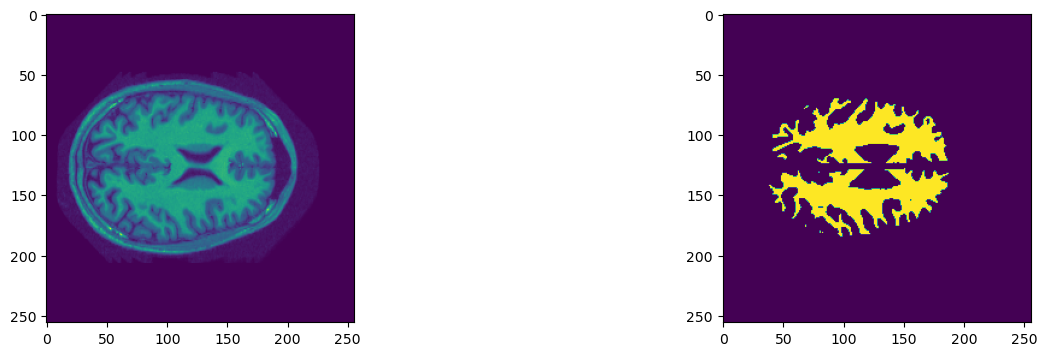

In [8]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1,2,figsize=(16,4))
idx=80
axis[0].imshow((dataset_train[idx]["gt_image"].squeeze()+1)/2)
axis[1].imshow(np.logical_or(dataset_train[idx]["segm"].squeeze()==41, dataset_train[idx]["segm"].squeeze()==2))
fig.show 

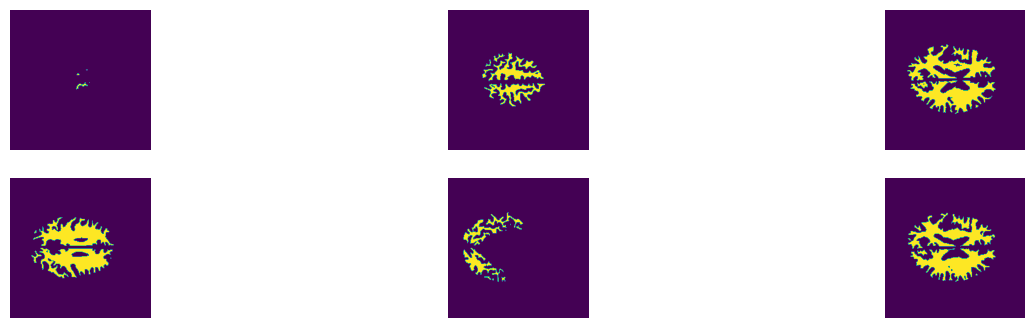

In [9]:
# Get 6 random sample
random_indices = np.random.randint(0, len(dataset_train) - 1, size=(6)) 

# Plot: t1n segmentations
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow(np.logical_or(dataset_train[idx]["segm"].squeeze()==41, dataset_train[idx]["segm"].squeeze()==2))
    axis[i//3,i%3].set_axis_off()
fig.show()

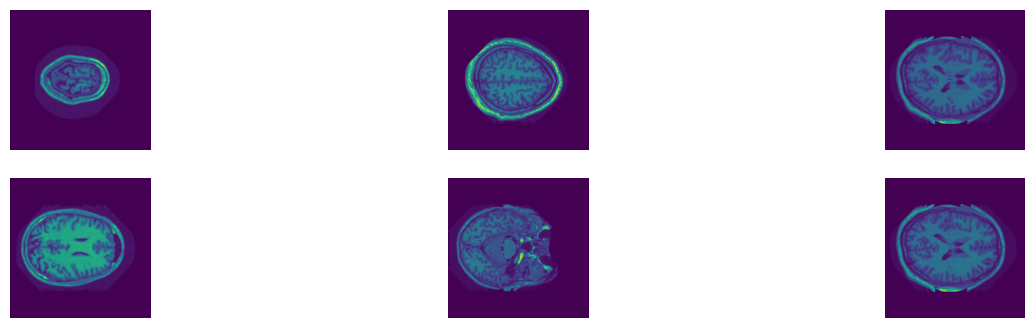

In [10]:
# Plot: t1n images
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow((dataset_train[idx]["gt_image"].squeeze()+1)/2)
    axis[i//3,i%3].set_axis_off()
fig.show()

### Random circles

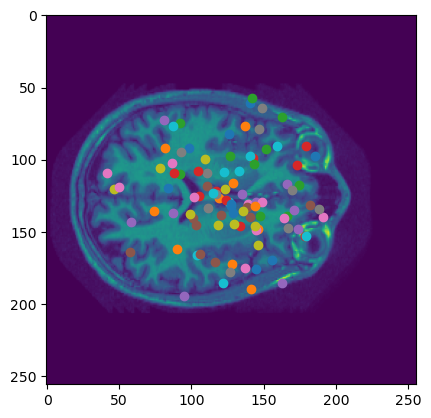

In [11]:
# visualize normal distributions of center points
centers=[]
for _ in np.arange(100):
    centers.append(torch.normal(torch.tensor([127.,127.]),torch.tensor(30.)))

plt.imshow((dataset_train[70]["gt_image"].squeeze()+1)/2) 
for center in centers:
    plt.scatter(center[0], center[1])

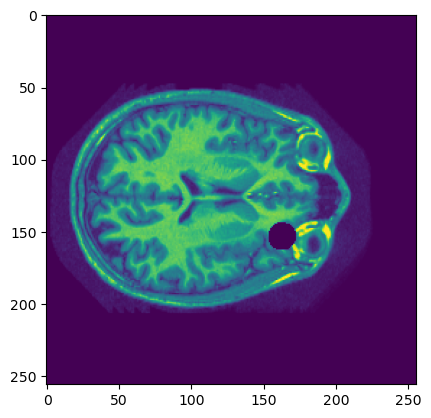

In [12]:
example=torch.zeros((10,256,256)).shape

#create circular mask with random center around the center point of the pictures and a radius between 3 and 40 pixels
center=np.random.normal([127,127],30, size=(example[0],2))
radius=np.random.uniform(low=3,high=40, size=(example[0]))

Y, X = np.ogrid[:256, :256] # gives two vectors, each containing the pixel locations. There's a column vector for the column indices and a row vector for the row indices.
dist_from_center = np.sqrt((X.T - center[:,0])[None,:,:]**2 + (Y-center[:,1])[:,None,:]**2) # creates matrix with euclidean distance to center

mask = dist_from_center <= radius # creates mask for pixels which are inside the radius
mask = 1-mask

plt.imshow(((dataset_train[70]["gt_image"].squeeze()+1)/2)*mask[:,:,4]) 

